In [225]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from joblib import dump, load

import tqdm
from tqdm import tqdm

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [226]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [227]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
ids = mailout_test['LNR']
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [228]:
feat_df = pd.read_csv('./data/AZDIAS_Feature_Summary_r003.csv')
azdias = pd.read_csv('./data/cleaned/azdias_subset.csv')

In [229]:
cat_feats = ['CAMEO_DEU_2015','OST_WEST_KZ']
range_feats = ['GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR','MIN_GEBAEUDEJAHR']

feats = list(set(feat_df['Attribute']))
num_feats = [feat for feat in feats if feat not in cat_feats+range_feats]

all_feats = cat_feats + range_feats + num_feats
special_feats = cat_feats + range_feats

model_feats = [ feat for feat in list(azdias.columns) if feat != 'LNR']

len(cat_feats),len(range_feats),len(num_feats),len(all_feats),len(model_feats)

(2, 4, 309, 315, 271)

In [230]:
train_feat = list(mailout_train.columns)
test_feat = list(mailout_test.columns)

In [231]:
#Find model features not in customer features
model_feat_notin_train = [feat for feat in model_feats if feat not in train_feat]
model_feat_notin_test = [feat for feat in model_feats if feat not in test_feat]

len(model_feat_notin_train),len(model_feat_notin_test)

(0, 0)

# TRAIN

In [232]:
#Response DF LNR,REPONSE,CLUSTER_LABEL
train_response_df = pd.DataFrame()
train_response_df['LNR'] = mailout_train['LNR']
train_response_df['RESPONSE'] = mailout_train['RESPONSE']
train_response_df.head()

,LNR,RESPONSE
0,1763,0
1,1771,0
2,1776,0
3,1460,0
4,1783,0


In [233]:
# extra_columns = ['RESPONSE']
# mailout_train_extra = mailout_train[extra_columns  + ['LNR']]
# mailout_train = mailout_train.drop(extra_columns, axis=1)
mailout_train = mailout_train[model_feats]
#mailout_train = mailout_train.drop('LNR', axis=1)
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,8.0,15.0,0.0,1.0,0.0,5.0,5D,2.0,0,...,3,3,0.0,2,6.0,9.0,3.0,3,2,4
1,1,13.0,1.0,0.0,2.0,0.0,5.0,5B,2.0,1,...,4,2,0.0,1,4.0,9.0,7.0,1,2,3
2,1,9.0,0.0,NaN,0.0,0.0,1.0,2D,4.0,0,...,7,3,0.0,1,NaN,9.0,2.0,3,1,4
3,2,6.0,4.0,0.0,2.0,0.0,2.0,2D,2.0,0,...,2,1,0.0,2,6.0,9.0,1.0,3,2,4
4,2,9.0,53.0,0.0,1.0,0.0,4.0,7B,6.0,0,...,7,1,0.0,1,6.0,9.0,3.0,3,1,3


In [234]:
mailout_train.shape

(42962, 271)

In [235]:
#FILLNA CATEGORICAL FEATS
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for cat in tqdm(cat_feats):
    mailout_train[cat] = mailout_train[cat].fillna('Unknown') 
    
    temp_list = []
    temp_df = feat_df[feat_df['Attribute'] == cat]
    values = [str(val) for val in temp_df['Value']]
    
    for val in mailout_train[cat]:
        try:
            val = str(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append('Unknown')
        except:
            temp_list.append('Unknown')
            
    mailout_train[str(cat)] = temp_list
    mailout_train[str(cat)] = le.fit_transform(mailout_train[cat])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.55it/s]


In [236]:
#FILLNA NUMERICAL FEATS
mailout_train_num_feats = [col for col in mailout_train.columns if col in num_feats]

for cat in tqdm(mailout_train_num_feats):
    temp_list = []
    temp_df = feat_df[feat_df['Attribute'] == cat]
    values = [int(val) for val in temp_df['Value']]
    
    for val in mailout_train[cat]:
        try:
            val = int(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append(np.NaN)
        except:
            temp_list.append(np.NaN)
    mailout_train[str(cat)] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:06<00:00, 40.19it/s]


In [237]:
#FILLNA RANGE FEATS
for feat in tqdm(range_feats):
    temp_list = []
    for val in mailout_train[feat]:
        try:
            val = int(val)
            temp_list.append(val)
        except:
            temp_list.append(np.NaN)
    mailout_train[feat] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 45.43it/s]


In [238]:
clean_mailout_train = mailout_train.fillna(mailout_train.mean())

In [239]:
clean_mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,8.0,2.850165,1.310966,1.00000,1.081505,5.0,21,2.0,0,...,3,3.0,1.338028,2.0,6.000000,9.0,3.0,3,2,4
1,1.0,13.0,1.000000,1.310966,2.00000,1.081505,5.0,19,2.0,1,...,4,2.0,1.338028,1.0,4.000000,9.0,7.0,1,2,3
2,1.0,9.0,2.850165,1.310966,1.76496,1.081505,1.0,8,4.0,0,...,7,3.0,1.338028,1.0,4.590321,9.0,2.0,3,1,4
3,2.0,6.0,4.000000,1.310966,2.00000,1.081505,2.0,8,2.0,0,...,2,1.0,1.338028,2.0,6.000000,9.0,1.0,3,2,4
4,2.0,9.0,2.850165,1.310966,1.00000,1.081505,4.0,31,6.0,0,...,7,1.0,1.338028,1.0,6.000000,9.0,3.0,3,1,3


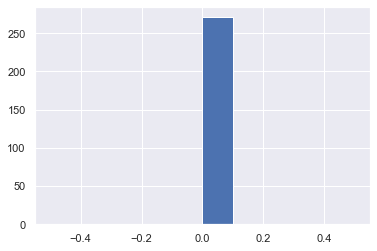

In [240]:
#figure out the nan per column
nans = clean_mailout_train.isna().sum().sort_values()
nans_df = pd.DataFrame()
nans_df['attr'] = list(nans.index)
nans_df['nan_count'] = list(nans.values)
len_df = clean_mailout_train.shape[0]
nans_df['pct_nan'] = [float(count)/len_df for count in nans_df['nan_count']]
nans_df['pct_nan'].hist()

In [241]:
nans_df[nans_df['pct_nan']>0]

,attr,nan_count,pct_nan


In [242]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

scaled_mailout_train = scaler.fit_transform(clean_mailout_train)
mailout_train = pd.DataFrame(scaled_mailout_train, columns=clean_mailout_train.columns)

In [243]:
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.651811,-1.251684,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,-0.291835,-0.745525,-0.224018,...,-0.421575,1.176640,3.148610e-15,1.146944,0.907737,0.291966,-0.572127,0.174577,0.824885,0.736410
1,-1.218983,0.161261,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,-0.433455,-0.745525,1.978334,...,0.053910,0.206405,3.148610e-15,-1.053221,-0.380126,0.291966,1.587486,-1.608634,0.824885,-0.200391
2,-1.218983,-0.969095,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,-1.212367,0.389014,-0.224018,...,1.480366,1.176640,3.148610e-15,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410
3,0.651811,-1.816862,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,-1.212367,-0.745525,-0.224018,...,-0.897061,-0.763830,3.148610e-15,1.146944,0.907737,0.291966,-1.651934,0.174577,0.824885,0.736410
4,0.651811,-0.969095,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.416268,1.523553,-0.224018,...,1.480366,-0.763830,3.148610e-15,-1.053221,0.907737,0.291966,-0.572127,0.174577,-1.212290,-0.200391


In [244]:
from joblib import dump, load

pca = load('dump/pca.joblib')

kmeans = load('dump/kmeans_model.joblib')

In [245]:
mailout_train_pca = pca.transform(mailout_train)
mailout_train_labels = kmeans.predict(mailout_train_pca)


In [246]:
train_label_df = pd.DataFrame(list(mailout_train_labels), columns=['CLUSTER_LABEL'])
train_label_df.head()

,CLUSTER_LABEL
0,4
1,3
2,2
3,12
4,12


In [247]:
train_response_df['CLUSTER_LABEL'] = train_label_df['CLUSTER_LABEL']
train_response_df.head()

,LNR,RESPONSE,CLUSTER_LABEL
0,1763,0,4
1,1771,0,3
2,1776,0,2
3,1460,0,12
4,1783,0,12


In [248]:
train_response_df['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

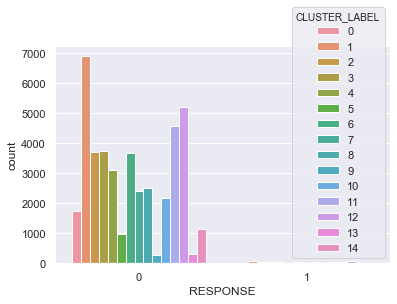

In [249]:
import seaborn as sns
sns.set(style="darkgrid")

ax = sns.countplot(x="RESPONSE", hue="CLUSTER_LABEL", data=train_response_df)

In [251]:
mailout_train.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.651811,-1.251684,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,-0.291835,-0.745525,-0.224018,...,-0.421575,1.176640,3.148610e-15,1.146944,0.907737,0.291966,-0.572127,0.174577,0.824885,0.736410
1,-1.218983,0.161261,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,-0.433455,-0.745525,1.978334,...,0.053910,0.206405,3.148610e-15,-1.053221,-0.380126,0.291966,1.587486,-1.608634,0.824885,-0.200391
2,-1.218983,-0.969095,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,-1.212367,0.389014,-0.224018,...,1.480366,1.176640,3.148610e-15,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410
3,0.651811,-1.816862,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,-1.212367,-0.745525,-0.224018,...,-0.897061,-0.763830,3.148610e-15,1.146944,0.907737,0.291966,-1.651934,0.174577,0.824885,0.736410
4,0.651811,-0.969095,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.416268,1.523553,-0.224018,...,1.480366,-0.763830,3.148610e-15,-1.053221,0.907737,0.291966,-0.572127,0.174577,-1.212290,-0.200391


In [292]:
X = mailout_train
y = train_response_df[['RESPONSE']]

In [293]:
X.shape, y.shape

((42962, 271), (42962, 1))

In [294]:
X[:3]

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.651811,-1.251684,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,-0.291835,-0.745525,-0.224018,...,-0.421575,1.176640,3.148610e-15,1.146944,0.907737,0.291966,-0.572127,0.174577,0.824885,0.736410
1,-1.218983,0.161261,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,-0.433455,-0.745525,1.978334,...,0.053910,0.206405,3.148610e-15,-1.053221,-0.380126,0.291966,1.587486,-1.608634,0.824885,-0.200391
2,-1.218983,-0.969095,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,-1.212367,0.389014,-0.224018,...,1.480366,1.176640,3.148610e-15,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410


### SMOTE OVER_SAMPLING

In [256]:
from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state=777)
X_res, y_res = resampler.fit_sample(X, y.values)
print(X_res.shape, y_res.shape)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(84860, 271) (84860,)


In [257]:
x_df = pd.DataFrame(X_res, columns=X.columns)
y_df = pd.DataFrame(y_res, columns=y.columns)

In [258]:
smote_train_df = pd.merge(x_df , y_df, left_index=True, right_index=True)

In [259]:
smote_train_df.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
0,0.651811,-1.251684,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,-0.291835,-0.745525,-0.224018,...,1.176640,3.148610e-15,1.146944,0.907737,0.291966,-0.572127,0.174577,0.824885,0.736410,0
1,-1.218983,0.161261,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,-0.433455,-0.745525,1.978334,...,0.206405,3.148610e-15,-1.053221,-0.380126,0.291966,1.587486,-1.608634,0.824885,-0.200391,0
2,-1.218983,-0.969095,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,-1.212367,0.389014,-0.224018,...,1.176640,3.148610e-15,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410,0
3,0.651811,-1.816862,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,-1.212367,-0.745525,-0.224018,...,-0.763830,3.148610e-15,1.146944,0.907737,0.291966,-1.651934,0.174577,0.824885,0.736410,0
4,0.651811,-0.969095,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.416268,1.523553,-0.224018,...,-0.763830,3.148610e-15,-1.053221,0.907737,0.291966,-0.572127,0.174577,-1.212290,-0.200391,0


In [260]:
smote_train_response_df = pd.DataFrame()
smote_train_response_df['RESPONSE'] = smote_train_df['RESPONSE']

In [261]:
smote_mailout_train_pca = pca.transform(x_df)
smote_mailout_train_labels = kmeans.predict(smote_mailout_train_pca)
smote_train_label_df = pd.DataFrame(list(smote_mailout_train_labels), columns=['CLUSTER_LABEL'])
smote_train_response_df['CLUSTER_LABEL'] = smote_train_label_df['CLUSTER_LABEL']
smote_train_response_df.head()

,RESPONSE,CLUSTER_LABEL
0,0,4
1,0,3
2,0,2
3,0,12
4,0,12


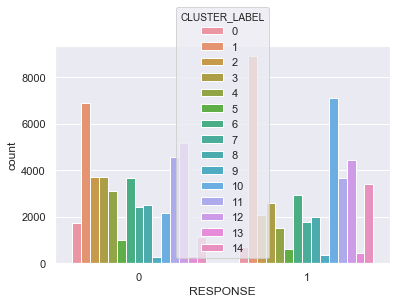

In [262]:
ax = sns.countplot(x="RESPONSE", hue="CLUSTER_LABEL", data=smote_train_response_df)

TRAIN THE MODEL

In [263]:
smote_train_df.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
0,0.651811,-1.251684,2.077321e-16,0.0,-1.254091,1.883594e-14,0.374223,-0.291835,-0.745525,-0.224018,...,1.176640,3.148610e-15,1.146944,0.907737,0.291966,-0.572127,0.174577,0.824885,0.736410,0
1,-1.218983,0.161261,-8.654534e-01,0.0,0.385328,1.883594e-14,0.374223,-0.433455,-0.745525,1.978334,...,0.206405,3.148610e-15,-1.053221,-0.380126,0.291966,1.587486,-1.608634,0.824885,-0.200391,0
2,-1.218983,-0.969095,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828,-1.212367,0.389014,-0.224018,...,1.176640,3.148610e-15,-1.053221,0.000000,0.291966,-1.112031,0.174577,-1.212290,0.736410,0
3,0.651811,-1.816862,5.378598e-01,0.0,0.385328,1.883594e-14,-1.136315,-1.212367,-0.745525,-0.224018,...,-0.763830,3.148610e-15,1.146944,0.907737,0.291966,-1.651934,0.174577,0.824885,0.736410,0
4,0.651811,-0.969095,2.077321e-16,0.0,-1.254091,1.883594e-14,-0.129290,0.416268,1.523553,-0.224018,...,-0.763830,3.148610e-15,-1.053221,0.907737,0.291966,-0.572127,0.174577,-1.212290,-0.200391,0


### UNDERSAMPLING

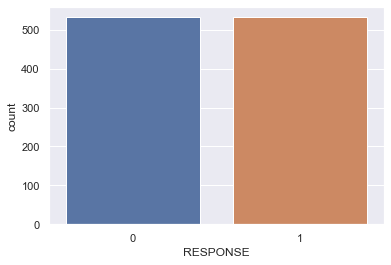

In [384]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X = mailout_train.drop(['RESPONSE'], axis=1)
y = train_response_df[['RESPONSE']]
X_res, y_res = rus.fit_resample(X, y)

UNDER_DF = pd.DataFrame(X_res)
UNDER_DF['RESPONSE'] = y_res
ax = sns.countplot(x="RESPONSE", data=UNDER_DF)

In [385]:
UNDER_DF.columns = list(X.columns) + ['RESPONSE']
UNDER_DF.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
0,0.000000,1.612612e-01,1.005631e+00,0.0,2.024747,1.883594e-14,3.742230e-01,0.699508,0.956284,1.978334,...,-7.638298e-01,3.148610e-15,1.146944,-0.380126,0.291966,-1.112031e+00,-1.608634,-1.212290,-0.200391,0
1,0.651811,-1.251684e+00,2.077321e-16,0.0,0.000000,1.883594e-14,-1.639828e+00,0.911939,0.389014,-0.224018,...,1.176640e+00,3.148610e-15,1.146944,0.000000,0.291966,-3.222388e-02,0.174577,0.824885,0.736410,0
2,0.000000,-5.019790e-16,2.077321e-16,0.0,0.000000,1.883594e-14,4.472092e-16,1.336800,-1.312794,-0.224018,...,-2.154354e-16,3.148610e-15,0.000000,0.000000,0.000000,-4.795306e-16,0.174577,0.824885,-1.137192,0
3,0.000000,-5.019790e-16,1.005631e+00,0.0,0.385328,1.883594e-14,-1.136315e+00,-0.645886,0.389014,-0.224018,...,1.176640e+00,3.148610e-15,1.146944,0.907737,0.291966,-3.222388e-02,0.174577,0.824885,-0.200391,0
4,0.000000,-5.019790e-16,2.077321e-16,0.0,0.000000,1.883594e-14,4.472092e-16,1.336800,1.523553,-0.224018,...,-2.154354e-16,3.148610e-15,0.000000,0.000000,0.000000,-4.795306e-16,0.174577,-1.212290,-0.200391,0


### CONDENSED NN SAMPLING

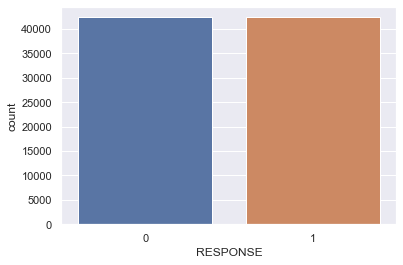

In [432]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto', n_jobs=-1)
X = mailout_train.drop(['RESPONSE'], axis=1)
y = mailout_train['RESPONSE']
X_res, y_res = smt.fit_sample(X, y)

UNDER_DF = pd.DataFrame(X_res)
UNDER_DF['RESPONSE'] = y_res
ax = sns.countplot(x="RESPONSE", data=UNDER_DF)

### TRAIN TEST SPLIT

In [433]:
#split data
### NORMAL
# X = mailout_train
# y = train_response_df[['RESPONSE']]
# NORMAL_DF = X
# NORMAL_DF['RESPONSE'] = y

# ### SMOTE OVERSAMPLING REPONSE = 1 
# X = smote_train_df[X.columns]
# y = smote_train_df['RESPONSE']

### UNDERSAMPLING RESPONSE = 1
y = UNDER_DF['RESPONSE']
X = UNDER_DF.drop(['RESPONSE'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 777)

### Random Forest

In [436]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True, max_depth=100) 

param_grid = { 
    'n_estimators': [100, 400, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [250,500,1000]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=10, n_jobs=-1)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 54.1min finished


{'max_depth': 1000, 'max_features': 'auto', 'n_estimators': 700}


In [437]:
y_pred = CV_rfc.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.9426889608642455


### XGBOOST

In [434]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [435]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

param_grid = { 
    'colsample_bytree': [0.5, 0.7,1],
    'n_estimators': [15,30,50],
    'alpha' : [0.001,0.05,0.1],
    'max_depth' : [1,3,5]
}

CV_xg_reg = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv= 5, verbose=10, n_jobs=-1)
CV_xg_reg.fit(X_train, y_train)
print(CV_xg_reg.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  7.5min


KeyboardInterrupt: 

In [ ]:
y_pred = CV_xg_reg.predict(X_val)

In [ ]:
print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

In [420]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("RMSE: %f" % (rmse))

RMSE: 0.486305


### EXPORT MODEL

In [438]:
#export model
# dump(xgboost, './dump/xgboost.joblib')
# dump(rfc, './dump/rfc.joblib')
dump(CV_rfc, './dump/cv_rfc.joblib')
# dump(xg_reg, './dump/xg_reg.joblib')
# dump(CV_xg_reg, './dump/cv_xg_reg.joblib')

['./dump/cv_rfc.joblib']

In [439]:
#import model
# xgboost = load('dump/xgboost.joblib')
# rfc = load('dump/rfc.joblib')
# xg_reg = load('dump/cv_xg_reg.joblib')
cv_rfc = load('dump/cv_rfc.joblib')

# Test Model

In [140]:
mailout_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,7.0,2.0,NaN,2.0,NaN,6.0,6,5.0,0,...,7,3.0,NaN,1.0,6.0,9.0,3.0,3,1,4
1,NaN,NaN,NaN,NaN,1.0,NaN,7.0,18,1.0,0,...,6,2.0,NaN,1.0,6.0,9.0,5.0,3,1,4
2,2.0,16.0,2.0,NaN,NaN,NaN,1.0,30,2.0,0,...,3,3.0,NaN,1.0,2.0,9.0,4.0,3,2,4
3,NaN,NaN,1.0,NaN,NaN,NaN,1.0,6,4.0,0,...,2,3.0,NaN,2.0,NaN,9.0,2.0,3,2,4
4,1.0,21.0,1.0,NaN,NaN,NaN,6.0,18,6.0,3,...,3,3.0,NaN,1.0,3.0,9.0,7.0,4,2,4


In [141]:
mailout_test = mailout_test[clean_mailout_train.columns]
mailout_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,7.0,2.0,NaN,2.0,NaN,6.0,6,5.0,0,...,7,3.0,NaN,1.0,6.0,9.0,3.0,3,1,4
1,NaN,NaN,NaN,NaN,1.0,NaN,7.0,18,1.0,0,...,6,2.0,NaN,1.0,6.0,9.0,5.0,3,1,4
2,2.0,16.0,2.0,NaN,NaN,NaN,1.0,30,2.0,0,...,3,3.0,NaN,1.0,2.0,9.0,4.0,3,2,4
3,NaN,NaN,1.0,NaN,NaN,NaN,1.0,6,4.0,0,...,2,3.0,NaN,2.0,NaN,9.0,2.0,3,2,4
4,1.0,21.0,1.0,NaN,NaN,NaN,6.0,18,6.0,3,...,3,3.0,NaN,1.0,3.0,9.0,7.0,4,2,4


In [142]:
X_test = mailout_test

In [143]:
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,7.0,2.0,NaN,2.0,NaN,6.0,6,5.0,0,...,7,3.0,NaN,1.0,6.0,9.0,3.0,3,1,4
1,NaN,NaN,NaN,NaN,1.0,NaN,7.0,18,1.0,0,...,6,2.0,NaN,1.0,6.0,9.0,5.0,3,1,4
2,2.0,16.0,2.0,NaN,NaN,NaN,1.0,30,2.0,0,...,3,3.0,NaN,1.0,2.0,9.0,4.0,3,2,4
3,NaN,NaN,1.0,NaN,NaN,NaN,1.0,6,4.0,0,...,2,3.0,NaN,2.0,NaN,9.0,2.0,3,2,4
4,1.0,21.0,1.0,NaN,NaN,NaN,6.0,18,6.0,3,...,3,3.0,NaN,1.0,3.0,9.0,7.0,4,2,4


In [144]:
#FILLNA CATEGORICAL FEATS
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for cat in tqdm(cat_feats):
    X_test[cat] = X_test[cat].fillna('Unknown') 
    
    temp_list = []
    temp_df = feat_df[feat_df['Attribute'] == cat]
    values = [str(val) for val in temp_df['Value']]
    
    for val in X_test[cat]:
        try:
            val = str(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append('Unknown')
        except:
            temp_list.append('Unknown')
            
    X_test[str(cat)] = temp_list
    X_test[str(cat)] = le.fit_transform(X_test[cat])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.50it/s]


In [145]:
#FILLNA NUMERICAL FEATS
test_num_feats = [col for col in mailout_test.columns if col in num_feats]

for cat in tqdm(test_num_feats):
    temp_list = []
    temp_df = feat_df[feat_df['Attribute'] == cat]
    values = [int(val) for val in temp_df['Value']]
    
    for val in X_test[cat]:
        try:
            val = int(val)
            if val in values:
                temp_list.append(val)
            else:
                temp_list.append(np.NaN)
        except:
            temp_list.append(np.NaN)
    X_test[str(cat)] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:07<00:00, 35.38it/s]


In [146]:
#FILLNA RANGE FEATS
for feat in tqdm(range_feats):
    temp_list = []
    for val in X_test[feat]:
        try:
            val = int(val)
            temp_list.append(val)
        except:
            temp_list.append(np.NaN)
    X_test[feat] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 40.82it/s]


In [147]:
X_test = X_test.fillna(X_test.mean())

In [291]:
#figure out the nan per column
nans = X_test.isna().sum().sort_values()
nans_df = pd.DataFrame()
nans_df['attr'] = list(nans.index)
nans_df['nan_count'] = list(nans.values)
len_df = X_test.shape[0]
nans_df['pct_nan'] = [float(count)/len_df for count in nans_df['nan_count']]
nans_df[nans_df['pct_nan']>0]

,attr,nan_count,pct_nan


In [201]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=mailout_test.columns)

In [202]:
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.666667,0.263158,0.111111,0.029947,0.500000,0.045833,0.833333,0.0,0.8,0.0,...,1.000000,1.000000,0.096545,0.0,1.000000,1.0,0.375,0.4,0.0,0.375
1,0.550505,0.549118,0.203368,0.029947,0.000000,0.045833,1.000000,0.0,0.0,0.0,...,0.833333,0.666667,0.096545,0.0,1.000000,1.0,0.625,0.4,0.0,0.375
2,0.666667,0.736842,0.111111,0.029947,0.385238,0.045833,0.000000,0.0,0.2,0.0,...,0.333333,1.000000,0.096545,0.0,0.200000,1.0,0.500,0.4,1.0,0.375
3,0.550505,0.549118,0.000000,0.029947,0.385238,0.045833,0.000000,0.0,0.6,0.0,...,0.166667,1.000000,0.096545,1.0,0.717497,1.0,0.250,0.4,1.0,0.375
4,0.333333,1.000000,0.000000,0.029947,0.385238,0.045833,0.833333,0.0,1.0,0.5,...,0.333333,1.000000,0.096545,0.0,0.400000,1.0,0.875,0.6,1.0,0.375


In [440]:
# y_pred = rfc.predict_proba(X_test)
y_pred = cv_rfc.predict_proba(X_test)
# y_pred = xg_reg.predict(X_test)

In [441]:
y_pred = [ probs[1] for probs in y_pred ]

In [442]:
submission_df = pd.DataFrame()
submission_df['LNR'] = ids
#submission_df['PROB_0'] = [ probs[0] for probs in y_pred ]
#submission_df['PROB_1'] = [ probs[1] for probs in y_pred ]
submission_df['PREDICTION'] = y_pred

In [443]:
submission_df.head()

,LNR,PREDICTION
0,1754,0.738571
1,1770,0.709318
2,1465,0.794286
3,1470,0.791429
4,1478,0.840000


In [427]:
submission_df['PREDICTION'].value_counts()

0.367750    15507
0.427076    13806
0.554940     6206
0.405971     3664
0.346646     2099
0.533835     1551
Name: PREDICTION, dtype: int64

In [444]:
submission_df.shape

(42833, 2)

In [445]:
submit = pd.DataFrame()
submit['LNR'] = submission_df['LNR']
submit['RESPONSE'] = submission_df['PREDICTION']

In [446]:
submit.to_csv('./data/submission.csv', index=False)